# <center> <font color='darkorange'>Подбор гиперпараметров алгоритмам классификации для датасета Predicting a Biological Response с платформы Kaggle.

Датасет представляет собой таблицу с молекулярными дескрипторами — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Все данные предварительно очищены и обработаны.
Также признаки закодированы и нормализованы.

**Наша цель**\
с помощью алгоритмов классификации ML предсказать биологический ответ молекул (признак *Activity*) по их химическому составу, который описывается всеми остальными факторами в таблице.\
В результате мы должны определить, какая модель будет наиболее качественно решать поставленную задачу.

В качестве оценки контроля качества модели будем использовать метрику F1-score - среднее гармоничное между precision(точность предсказаний класса) и recall(полнота, способность модели определять класс).

Формула F1-score:
$$F_1 = 2\frac{presicion * recall}{precision + recall}$$

#### <font color='orange'>**Задачи:**</font>
1. Обучить две модели: логистическую регрессию, случайный лес (на параметрах по умолчанию без подбора).
2. Сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации: GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna.
3. Сравнить результаты значений метрики f1 на тестовой выборке после различных методов оптимизации.

Датасет для исследования взят с соревнования [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse)

In [79]:
# импортируем библиотеки
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.model_selection import cross_val_score  # среднее значение метрики при кросс-валидации

from sklearn.model_selection import GridSearchCV # оптимизатор поиска гиперпараметров по сетке
from sklearn.model_selection import RandomizedSearchCV # оптимизатор рандомного поиска гиперпараметров по заданной сетке

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval

import optuna

%matplotlib inline
plt.style.use('seaborn-v0_8')

import warnings
warnings.filterwarnings('ignore')

Для загрузки данных на локальный комьютер воспользуйтесь ссылкой https://drive.google.com/uc?id=1TlCdFMDFofyN7EIrIzXwwjcMBo4yHb1a 

In [80]:
# загружаем данные
df = pd.read_csv('_train_sem09__1_.zip')
df.head().style.set_properties(**{'background-color': 'lightgrey',
                           'color': 'black',
                           'border-color': 'white'})

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12


In [81]:
# посмотрим на размер и тип данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


### <font color='green'>1. Создание моделей логистической регрессии и случайного леса без подбора гиперпараметров. Сравнение значений метрики f1-score.</font>

##### **1.1 Логистическая регрессия**

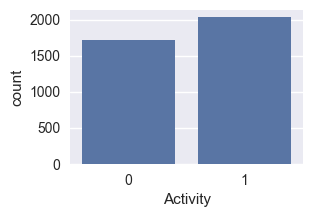

In [82]:
# проверим сбалансированность классов
fig = plt.subplots(figsize=(3,2))
sns.countplot(data=df, x='Activity');

Классы можно назвать сбалансированными, нам не требуется стратификация.

Сделаем разбиение датасета на тренировочную и тестовую выборку в соотношении 75/25.

In [83]:
# отделяем таргет от матрицы наблюдений
X = df.drop(columns='Activity')
y = df['Activity']

# сразу зададим закономерность случайности воспроизведения, так как нам это понадобиться во всех моделях
random_state = 42

# производим разбиение на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
print('Размерность тренировочной выборки: {}, размерность тестовой выборки: {}'.format(X_train.shape, X_test.shape))

Размерность тренировочной выборки: (2813, 1776), размерность тестовой выборки: (938, 1776)


In [84]:
# инициализируем алгоритм логистической регрессии c параметрами по умолчанию
log_model = linear_model.LogisticRegression(random_state=random_state, max_iter=1000)
# обучаем на тренировочной выборке
%time log_model.fit(X_train, y_train)
# делаем предсказание на тренировочной выборке
y_train_pred = log_model.predict(X_train)
# делаем предсказание на тестовой выборке
y_test_pred = log_model.predict(X_test)
# выводим значения метрики f1-score
print('F1-score на тренировочной выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_train, y_train_pred, average=None),3))
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_test_pred, average=None),3))

CPU times: total: 1.72 s
Wall time: 1.22 s
F1-score на тренировочной выборке для класса 0 и класса 1:  [0.874 0.892]
F1-score на тестовой выборке для класса 0 и класса 1:  [0.719 0.792]


##### **1.2 Модель алгоритма случайного леса Random Forest**

In [85]:
# инициализируем алгоритм Random Forest, ограничим лес только максимальной глубиной дерева
forest_model = ensemble.RandomForestClassifier(
    max_depth=20,                                                  # глубина дерева
    random_state=random_state
)
# обучаем модель
%time forest_model.fit(X_train, y_train)
# делаем предсказание на тренировочной выборке 
y_train_pred = forest_model.predict(X_train)
# делаем предсказание на тестовой выборке
y_test_pred = forest_model.predict(X_test)
# выводим значения метрики f1-score
print('F1-score на тренировочной выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_train, y_train_pred, average=None),3))
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_test_pred, average=None),3))

CPU times: total: 1.69 s
Wall time: 2.21 s
F1-score на тренировочной выборке для класса 0 и класса 1:  [1. 1.]
F1-score на тестовой выборке для класса 0 и класса 1:  [0.78  0.835]


<font color='orange'>**ВЫВОД**</font>\
Модель случайного леса показала лучше качество для предсказания классов, чем логистическая регрессия.
А теперь мы с помощью оптимизаторов подберем наиболее оптимальные гиперпараметры для обоих этих моделей.\
Значение метрики на тренировочной выборке модели случайного леса равно 1, это чаще всего указывает на переобучение (overfitting), на новых данных модель может выдавать плохие результаты, полностью подстроившись под обучающие данные.

### <font color='green'>2. Подбор гиперпараметров для моделей с помощью алгоритмов оптимизации</font>

##### **2.1 GridSearchCV**

Алгоритм GridSearchCV перебирает все возможные комбинации сетки гиперпараметров, которую мы зададим. Плюсом является, что оптимизатор запускает кросс-валидацию для каждой комбинации гиперпараметров и автоматическое построение новой модели на тренировочном наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.

##### 2.1.1. Подбор гиперпараметров для логистической регрессии

Алгоритм оптимизации в логистической регрессии зависит от типа регуляризации:
* *lfbgs, sag, newton-cg* - ['none', 'l2];
* *liblinear*  - ['l1', 'l2'];
* *saga* - ['l1', 'l2', 'elasticnet', 'none']

In [86]:
# создаем сетку гиперпараметров из нескольких словарь
param_grid_log = [{'penalty': ['l2', 'none'] ,              # тип регуляризации
              'solver': ['lbfgs', 'sag', 'newton-cg'],      # алгоритм оптимизации
               'C': np.linspace(0.1, 1, 10, dtype=float)},  # уровень силы регурялизации
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': np.linspace(0.1, 1, 10, dtype=float)}
]
# создаем объект класса GridSearchCV и передаем гиперпараметры
grid_search_log = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=1000),   # алгоритм
    param_grid=param_grid_log,                                                     # сетка гиперпараметров для перебора
    cv=5,                                                                          # количество фолдов при кросс-валидации
    scoring='f1',                                                                  # метрика оценки качества
    n_jobs = -1                                                                    # используем все ядра для расчета
)  
# выводим время перебора сетки гиперпараметров и обучения
%time grid_search_log.fit(X_train, y_train) 
# выводим значение метрики f1-score для тестовой выборки
print('F1-score на тестовой выборке: ', np.round(grid_search_log.score(X_test, y_test),3))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_log.best_params_))
print('Наилучшее значение f1-score при кросс-валидаци: {:.3f}'.format(grid_search_log.best_score_))

CPU times: total: 58.5 s
Wall time: 19min 2s
F1-score на тестовой выборке:  0.792
Наилучшие значения гиперпараметров: {'C': 0.30000000000000004, 'penalty': 'l1', 'solver': 'saga'}
Наилучшее значение f1-score при кросс-валидаци: 0.785


##### 2.1.2 Подбор гиперпараметров для алгоритма случайного леса

In [87]:
# создаем сетку гиперпараметров
param_grid_rf = [{'n_estimators': list(range(100, 601, 100)),       # количество деревьев в лесу
               'criterion': ['gini', 'entropy'],              # критерий информативности
               'max_depth': list(range(15, 31, 5)),                     # максимальная глубина одного дерева
               'min_samples_leaf': [3, 5, 7]}                 # минимальное число объектов в листе
]
# создаем объект класса GridSearchCV и передаем гиперпараметры
grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),   # алгоритм случайного леса
    param_grid=param_grid_rf,                                 # сетка гиперпараметров для перебора
    cv=5,                                                     # количество фолдов при кросс-валидации
    scoring='f1',                                             # метрика оценки качества
    n_jobs = -1                                               # используем все ядра для расчета
)  
# выводим затраченное время на перебор и обучение
%time grid_search_rf.fit(X_train, y_train) 
# выводим значение метрики f1-score для тестовой выборки
print('F1-score на тестовой выборке: ', np.round(grid_search_rf.score(X_test, y_test),3))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_rf.best_params_))
print('Наилучшее значение f1-score при кросс-валидаци: {:.3f}'.format(grid_search_rf.best_score_))

CPU times: total: 4.78 s
Wall time: 14min 17s
F1-score на тестовой выборке:  0.826
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 200}
Наилучшее значение f1-score при кросс-валидаци: 0.815


Визуализируем, как значение метрики менялось в зависимости от значений гиперпараметров в обоих моделях оптимизатора GridSearchCV при кросс-валидации.

In [88]:
# преобразуем результаты кросс-валидации для модели grid_search_log в датафрейм и выведем названия столбцов
result_log = pd.DataFrame(grid_search_log.cv_results_)
result_log.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [89]:
# преобразуем результаты кросс-валидации для модели grid_search_rf в датафрейм и выведем названия столбцов
result_rf = pd.DataFrame(grid_search_rf.cv_results_)
result_rf.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_leaf',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

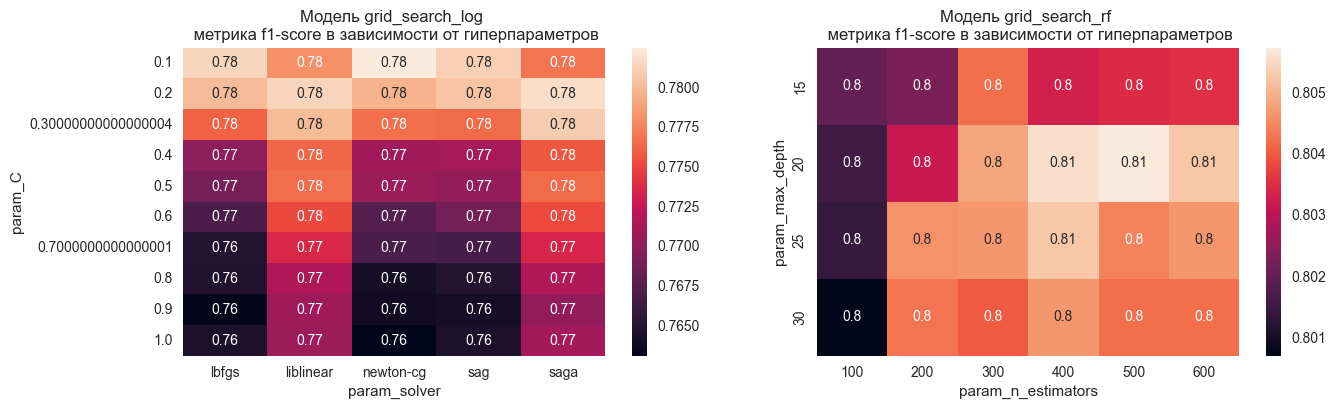

In [90]:
# создаем сводную таблицу на основе средних значений метрики f1 модели grid_search_log при кросс-валидации
# в зависимости от коэффициента регуляризации C и алгоритма оптимизации solver
visual_gscv_log = pd.pivot_table(pd.DataFrame(grid_search_log.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
# создаем сводную таблицу на основе средних значений метрики f1 модели grid_search_rf при кросс-валидации
# в зависимости от максимальной глубины дерева max_depth и количества деревьев n_estimators
visual_gscv_rf = pd.pivot_table(pd.DataFrame(grid_search_rf.cv_results_),
                        values='mean_test_score', index='param_max_depth',
                        columns='param_n_estimators')

# визуализируем тепловые карты сводных таблиц
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
# визуализируем, как менялось значение метрики f1_score при различных гиперпараметрах у модели логистической регрессии
heatmap_1 = sns.heatmap(visual_gscv_log, annot=True, ax=ax[0])
heatmap_1.set_title('Модель grid_search_log \n метрика f1-score в зависимости от гиперпараметров')
# визуализируем, как менялось значение метрики f1_score при различных гиперпараметрах у модели случайного леса
heatmap_2 = sns.heatmap(visual_gscv_rf, annot=True, ax=ax[1])
heatmap_2.set_title('Модель grid_search_rf \n метрика f1-score в зависимости от гиперпараметров');

<font color='orange'>**ВЫВОД**</font>\
Без подбора гиперпараметров значение метрики F1 на тестовой выборке 
* в логистической регрессии равно 0.792, 
* а алгоритм случайного леса улучшил метрику до 0.835.

Оптимизатор GridSearchCV не привел к улучшению качества ни одной из моделей (0.792 и 0.826 соответственно).


##### **2.2 RandomizedSearchCV**

Данный оптимизатор перебирает не все возможные комбинации, а рандомно выбирает n (параметр n_iter) возможных комбинаций. Также оптимизатор запускает кросс-валидацию для случайной комбинации гиперпараметров и автоматическое построение новой модели на тренировочном наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.

##### 2.2.1 Подбор гиперпараметров для логистической регресии

In [91]:
# задаем сетку гиперпараметров из словарей в связи с зависимостью алгоритма оптимизации LogisticRegression от типа штрафа (penalty)
param_distributions_log = [{'penalty': ['l2', 'none'] ,     # тип регуляризации
              'solver': ['lbfgs', 'sag', 'newton-cg'],      # алгоритм оптимизации
               'C': np.linspace(0.1, 1, 10, dtype=float)},  # уровень силы регурялизации
              {'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga'],
               'C': np.linspace(0.1, 1, 10, dtype=float)},
              {'penalty': ['elasticnet', 'none'],
               'solver': ['saga'],
               'C': np.linspace(0.1, 1, 10, dtype=float),
               'l1_ratio': np.linspace(0.1, 1, 10, dtype=float)}
]
# создаем объект класса RandomizedSearchCV и передаем гиперпараметры
random_search_log = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=1000),  # алгоритм логистической регрессии
    param_distributions=param_distributions_log,                                    # сетка гиперпараметров
    cv=5,                                                                           # количество фолдов при кросс-валидации
    scoring='f1',                                                                   # метрика оценки качества
    n_iter = 40,                                                                    # количество случайных комбинаций 
    n_jobs = -1
)  
# выводим затраченное время на случайный перебор и обучение
%time random_search_log.fit(X_train, y_train) 
# выводим значение метрики f1-score на тестовой выборке
print('F1-score на тестовой выборке: ', np.round(random_search_log.score(X_test, y_test),3))
print("Наилучшие значения гиперпараметров: {}".format(random_search_log.best_params_))
print("Наилучшее значение f1-score при кросс-валидаци: {:.3f}".format(random_search_log.best_score_))

CPU times: total: 1.64 s
Wall time: 10min 42s
F1-score на тестовой выборке:  0.8
Наилучшие значения гиперпараметров: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}
Наилучшее значение f1-score при кросс-валидаци: 0.782


##### 2.2.2 Подбор гиперпараметров для алгоритма случайного леса

In [92]:
# задаем сетку гиперпараметров
param_distributions_rf = [{'n_estimators': list(range(100, 701, 50)),     # количество деревьев в лесу
              'criterion': ['gini', 'entropy'],                           # критерий информативности
               'max_depth': list(range(15, 31, 1)),                       # максимальная глубина одного дерева
               'min_samples_leaf': [3, 5, 7] }                            # минимальное число объектов в листе
]
# создаем объект класса RandomizedSearchCV и передаем гиперпараметры
random_search_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), # алгоритм случайного леса
    param_distributions=param_distributions_rf,                           # сетка гиперпараметров
    cv=5,                                                                 # количество фолдов при кросс-валидации
    scoring='f1',                                                         # метрика оценки качества
    n_iter = 40,                                                          # количество случайных комбинаций 
    n_jobs = -1
)    
# выводим затраченное время на случайный перебор и обучение
%time random_search_rf.fit(X_train, y_train) 
# выводим значение метрики f1-score на тестовой выборке
print('F1-score на тестовой выборке: ', np.round(random_search_rf.score(X_test, y_test),3))
print("Наилучшие значения гиперпараметров: {}".format(random_search_rf.best_params_))
print("Наилучшее значение f1-score при кросс-валидаци: {:.3f}".format(random_search_rf.best_score_))

CPU times: total: 9.86 s
Wall time: 4min 3s
F1-score на тестовой выборке:  0.834
Наилучшие значения гиперпараметров: {'n_estimators': 550, 'min_samples_leaf': 3, 'max_depth': 25, 'criterion': 'entropy'}
Наилучшее значение f1-score при кросс-валидаци: 0.811


Визуализируем, как значение метрики менялось в зависимости от значений гиперпараметров в обоих моделях оптимизатора RandomSearchCV при кросс-валидации.

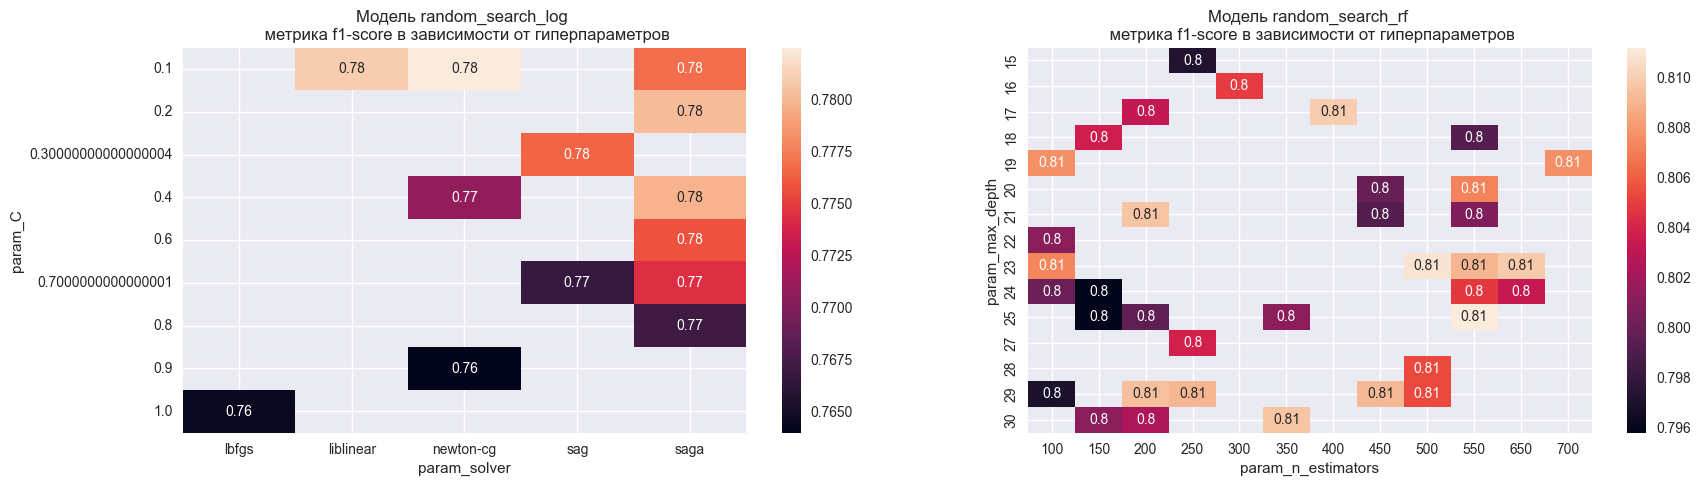

In [93]:
# создаем сводную таблицу на основе средних значений метрики f1 модели random_search_log при кросс-валидации
# в зависимости от коэффициента регуляризации C и алгоритма оптимизации solver
visual_rscv_log = pd.pivot_table(pd.DataFrame(random_search_log.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
# создаем сводную таблицу на основе средних значений метрики f1 модели random_search_rf при кросс-валидации
# в зависимости от максимальной глубины дерева max_depth и количества деревьев n_estimators
visual_rscv_rf = pd.pivot_table(pd.DataFrame(random_search_rf.cv_results_),
                        values='mean_test_score', index='param_max_depth',
                        columns='param_n_estimators')

# визуализируем тепловые карты сводных таблиц
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# визуализируем, как менялось значение метрики f1_score при различных гиперпараметрах у модели логистической регрессии
heatmap_1 = sns.heatmap(visual_rscv_log, annot=True, ax=ax[0])
heatmap_1.set_title('Модель random_search_log \n метрика f1-score в зависимости от гиперпараметров')
# визуализируем, как менялось значение метрики f1_score при различных гиперпараметрах у модели случайного леса
heatmap_2 = sns.heatmap(visual_rscv_rf, annot=True, ax=ax[1])
heatmap_2.set_title('Модель random_search_rf \n метрика f1-score в зависимости от гиперпараметров');


<font color='orange'>**ВЫВОД**</font>\
Оптимизатор RandomSearchCV после случайного перебора 40 различных комбинаций оптимизировал модель логистической регрессии  Logisticregression F1=0.800, модель RandomForestClassifier осталась в прежнем качестве F1=0.834 по сравнению с default-моделью, но лучше по сравнению с результатом оптимизатора GridSearchCV.

##### **2.3 Hyperopt**

Основой является байесовская оптимизация, которая учитывает информацию о прошлых комбинациях. Мы будем использовать алгоритм Tree-Structured Rarzen Estimators TPE.
Для оптимизатора hyperopt нам необходимо создать функцию для минимизации (может только минимизировать), она примимает словарь значений гиперпараметров и возвращает значение метрики.

##### 2.3.1 Подбор гиперпараметров для логистической регресии

Для логистической регрессии задаим несколько  пространств, так как алгоритм оптимизации(solver) зависит от типа регуляризации(penalty).

In [94]:
# зададим пространствf поиска гиперпараметров
space_log_1 = {'solver': hp.choice('solver', ['liblinear', 'saga']),   # алгоритм оптимизации
           'penalty': hp.choice('penalty', ['l1', 'l2']),              # тип регуляризации
           'C': hp.quniform('C', 0.1, 1, 0.1)}                         # уровень регуляризации
space_log_2 = {'solver': hp.choice('solver', ['lbfgs', 'sag', 'newton-cg']),   
           'penalty': hp.choice('penalty', ['l2', None]),          
           'C': hp.quniform('C', 0.1, 1, 0.1)}                     

# создаем функцию
def hyperopt_log(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    try:
         model_log = linear_model.LogisticRegression(solver=params['solver'], penalty=params['penalty'],
                                                      C=float(params['C']), random_state=random_state, max_iter=100)
    except KeyError:
         model_log = linear_model.LogisticRegression(solver=params['solver'], penalty=params['penalty'],
                                                      C=float(params['C']), random_state=random_state, max_iter=100)

    # используем эту комбинацию для построения модели
    model_log = linear_model.LogisticRegression(**params, random_state=random_state)
    # получим значение метрики с помощью кросс-валидации
    score = cross_val_score(model_log, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # возвращаем среднее значение метрики на кросс-валидации со знаком минус, т.к. метрику необходимо минимизировать
    return -score

Подберем лучшие гиперпараметры для пространств space_log_1 и space_log_2.

In [95]:
%%time
# начинаем подбор гиперпараметров
# создадим объект класса Trials
trials_log = Trials() # используется для логирования результатов
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
best_log_1 = fmin(hyperopt_log,   # наша функция 
          space=space_log_1,    # пространство гиперпараметров
          algo=tpe.suggest,     # алгоритм оптимизации, установлен по умолчанию
          max_evals=30,         # максимальное количество итераций
          trials=trials_log,    # логирование результатов
          rstate=np.random.default_rng(random_state)  # фиксируем для повторяемости результата
         )
print('Наилучшие значения гиперпараметров {}'.format(best_log_1))
print('Наилучшие значения гиперпараметров {}'.format(space_eval(space_log_1, best_log_1)))

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 30/30 [02:18<00:00,  4.61s/trial, best loss: -0.783799799962682] 
Наилучшие значения гиперпараметров {'C': 0.30000000000000004, 'penalty': 0, 'solver': 0}
Наилучшие значения гиперпараметров {'C': 0.30000000000000004, 'penalty': 'l1', 'solver': 'liblinear'}
CPU times: total: 1.47 s
Wall time: 2min 18s


Построим первую модель логистической регрессии на гиперпараметрах, подобранных в первом пространстве.

In [96]:
# рассчитаем f1-score с помощью оптимальных параметров логистической регрессии согласно hyperopt оптимизатору
model_log_hyperopt_1 = linear_model.LogisticRegression(
    random_state=random_state, 
    solver=space_eval(space_log_1, best_log_1)['solver'],
    penalty=space_eval(space_log_1, best_log_1)['penalty'],
    C=float(best_log_1['C'])
)
model_log_hyperopt_1.fit(X_train, y_train)
# делаем предсказание для тренировочной выборки
y_train_pred = model_log_hyperopt_1.predict(X_train)
# делаем предсказание для тестовой выборки
y_test_pred = model_log_hyperopt_1.predict(X_test)
# выводим значения метрики f1-score
print('F1-score на тренировочной выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_train, y_train_pred, average=None),3))
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_test_pred, average=None),3))

F1-score на тренировочной выборке для класса 0 и класса 1:  [0.797 0.833]
F1-score на тестовой выборке для класса 0 и класса 1:  [0.716 0.792]


In [97]:
%%time
# начинаем подбор гиперпараметров во втором пространстве
# создадим объект класса Trials
trials_log_2 = Trials() # используется для логирования результатов
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
best_log_2 = fmin(hyperopt_log,   # наша функция 
          space=space_log_2,    # пространство гиперпараметров
          algo=tpe.suggest,   # алгоритм оптимизации, установлен по умолчанию
          max_evals=30,       # максимальное количество итераций
          trials=trials_log_2,  # логирование результатов
          rstate=np.random.default_rng(random_state)  # фиксируем для повторяемости результата
         )
print('Наилучшие значения гиперпараметров {}'.format(best_log_2))
print('Наилучшие значения гиперпараметров {}'.format(space_eval(space_log_2, best_log_2)))

100%|██████████| 30/30 [03:03<00:00,  6.11s/trial, best loss: -0.7816872880779762]
Наилучшие значения гиперпараметров {'C': 0.2, 'penalty': 0, 'solver': 0}
Наилучшие значения гиперпараметров {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}
CPU times: total: 1.58 s
Wall time: 3min 3s


Построим вторую модель логистической регрессии на гиперпараметрах, подобранных во втором пространстве.

In [98]:
# рассчитаем f1-score с помощью оптимальных параметров логистической регрессии согласно hyperopt оптимизатору
model_log_hyperopt_2= linear_model.LogisticRegression(
    random_state=random_state, 
    solver=space_eval(space_log_2, best_log_2)['solver'],
    penalty=space_eval(space_log_2, best_log_2)['penalty'],
    C=float(best_log_2['C'])
)
model_log_hyperopt_2.fit(X_train, y_train)
# делаем предсказание для тренировочной выборки
y_train_pred = model_log_hyperopt_2.predict(X_train)
# делаем предсказание для тестовой выборки
y_test_pred = model_log_hyperopt_2.predict(X_test)
# выводим значения метрики f1-score
print('F1-score на тренировочной выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_train, y_train_pred, average=None),3))
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_test_pred, average=None),3))

F1-score на тренировочной выборке для класса 0 и класса 1:  [0.84  0.865]
F1-score на тестовой выборке для класса 0 и класса 1:  [0.715 0.792]


Гиперпараметры первого пространства {'C': 0.30000000000000004, 'penalty': 'l1', 'solver': 'liblinear'} и  гиперпараметры второго пространства {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'} дали равнозначный результат метрики f1-score (0.792), что говорит об отсутствии улучшения качества.

##### 2.3.2 Подбор гиперпараметров для алгоритма случайного леса

In [114]:
# зададим пространство поиска гиперпараметров
space_rf={'n_estimators': hp.quniform('n_estimators', 200, 700, 50) ,       # количество деревьев
        'criterion': hp.choice('criterion', ['gini', 'entropy']),           # критерий информативности
        'max_depth': hp.quniform('max_depth', 15, 31, 1),                   # максимальная глубина дерева
        'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 10, 1)       # количество объектов в листе
        }                                        
# создаем функцию
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'criterion': params['criterion'],
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model_rf = ensemble.RandomForestClassifier(**params, random_state=random_state)
    # получим значение метрики с помощью кросс-валидации
    score = cross_val_score(model_rf, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()

    # возвращаем среднее значение метрики на кросс-валидации со знаком минус, т.к. метрику необходимо минимизировать
    return -score

In [115]:
%%time
# начинаем подбор гиперпараметров
# создадим объект класса Trials
trials_rf = Trials() # используется для логирования результатов
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
best_rf=fmin(hyperopt_rf,             # функция, которая принимает гиперпараметры
          space=space_rf,             # пространство гиперпараметров
          algo=tpe.suggest,           # алгоритм оптимизации, установлен по умолчанию
          max_evals=30,               # максимальное количество итераций
          trials=trials_rf,           # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print('Наилучшие значения гиперпараметров {}'.format(best_rf))
print('Наилучшие значения гиперпараметров {}'.format(space_eval(space_rf, best_rf)))

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 30/30 [05:33<00:00, 11.10s/trial, best loss: -0.8114667792397977]
Наилучшие значения гиперпараметров {'criterion': 0, 'max_depth': 19.0, 'min_samples_leaf': 3.0, 'n_estimators': 200.0}
Наилучшие значения гиперпараметров {'criterion': 'gini', 'max_depth': 19.0, 'min_samples_leaf': 3.0, 'n_estimators': 200.0}
CPU times: total: 1.61 s
Wall time: 5min 33s


In [116]:
# рассчитаем f1-score с помощью наилучших гиперпараметров алгоритма случайного леса согласно hyperopt оптимизатору
model_rf_hyperopt = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best_rf['n_estimators']),
    criterion = space_eval(space_rf, best_rf)['criterion'],
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf'])
)
# обучаем модель
model_rf_hyperopt.fit(X_train, y_train)
# делаем предсказание на тренировочной выборке
y_train_pred = model_rf_hyperopt.predict(X_train)
# делаем предсказание на тестовой выборке
y_test_pred = model_rf_hyperopt.predict(X_test)
# выводим значения метрики f1-score
print('F1-score на тренировочной выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_train, y_train_pred, average=None),3))
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_test_pred, average=None),3))

F1-score на тренировочной выборке для класса 0 и класса 1:  [0.968 0.972]
F1-score на тестовой выборке для класса 0 и класса 1:  [0.775 0.831]


<font color='orange'>**ВЫВОД**</font>\
Оптимизатор Hyperopt не удивил нас, значения метрики f1 не превзошли default-значений, а в алгоритме случайного леса даже немного снизилось качесто: 
* Logisticregression F1=0.792, 
* RandomForestClassifier F1=0.831.

##### **2.4 Optuna**

Основой также является байесовская оптимизация, которая учитывает информацию о прошлых комбинациях, но также он удаляет "плохие" комбинации из рассмотрения(в которых модель дает качество ниже медианы из уже рассмотренных). По умолчанию используется алгоритм поиска Tree-Structured Rarzen Estimators TPE, который мы и будем применять.

##### 2.4.1 Подбор гиперпараметров для логистической регресии

In [102]:
# функция с алгоритмами оптимизации liblinear и saga для логистической регрессии
def optuna_log(trial):
    # задаем пространствo поиска гиперпараметров
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.1, 1, step=0.1)
  
    # создаем модель
    model_optuna_log = linear_model.LogisticRegression(solver=solver,
                                          penalty=penalty,
                                          C=C,
                                          random_state=random_state)
    # получим значение метрики с помощью кросс-валидации
    score = cross_val_score(model_optuna_log, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score

In [103]:
# функция с алгоритмами оптимизации lbfgs, sag и newton-cg для логистической регрессии
def optuna_log_2(trial):
    # задаем пространствo поиска гиперпараметров
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'newton-cg'])
    penalty = trial.suggest_categorical('penalty', ['l2', None])
    C = trial.suggest_float('C', 0.1, 1, step=0.1)

    # создаем модель
    model_optuna_log = linear_model.LogisticRegression(solver=solver,
                                          penalty=penalty,
                                          C=C,
                                          random_state=random_state)
    # получим значение метрики с помощью кросс-валидации
    score = cross_val_score(model_optuna_log, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score

In [104]:
%%time
# cоздаем объект исследования логистической регрессии для первого набора гиперпараметров
# максимизируем метрику f1 direction='maximize'
study_log = optuna.create_study(study_name='LogisticRegression', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз из пространства функции optuna_log
study_log.optimize(optuna_log, n_trials=30)

# выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study_log.best_params))
print('F1_score на тренировочной выборке: {:.3f}'.format(study_log.best_value))

[I 2024-03-21 17:48:32,799] A new study created in memory with name: LogisticRegression
[I 2024-03-21 17:48:45,723] Trial 0 finished with value: 0.7795364637485668 and parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.8}. Best is trial 0 with value: 0.7795364637485668.
[I 2024-03-21 17:48:47,086] Trial 1 finished with value: 0.776849868090754 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}. Best is trial 0 with value: 0.7795364637485668.
[I 2024-03-21 17:48:55,972] Trial 2 finished with value: 0.7698305104084158 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.9}. Best is trial 0 with value: 0.7795364637485668.
[I 2024-03-21 17:49:04,666] Trial 3 finished with value: 0.7702434208146484 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.8}. Best is trial 0 with value: 0.7795364637485668.
[I 2024-03-21 17:49:16,492] Trial 4 finished with value: 0.7805603579260372 and parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.30000000000000004}. Best 

Наилучшие значения гиперпараметров {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.30000000000000004}
F1_score на тренировочной выборке: 0.784
CPU times: total: 1.67 s
Wall time: 1min 43s


In [105]:
# посмотрим на динамику оптимизации гиперпараметров в первом пространстве
optuna.visualization.plot_optimization_history(study_log, target_name="f1_score")

In [106]:
%%time
# cоздаем объект исследования логистической регрессии для второго набора гиперпараметров
# максимизируем метрику f1 direction='maximize'
study_log_2 = optuna.create_study(study_name='LogisticRegression', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз из пространства функции optuna_log_2
study_log_2.optimize(optuna_log_2, n_trials=30)

# выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study_log_2.best_params))
print('F1_score на тренировочной выборке: {:.3f}'.format(study_log_2.best_value))

[I 2024-03-21 17:50:16,619] A new study created in memory with name: LogisticRegression


[I 2024-03-21 17:50:19,069] Trial 0 finished with value: 0.7468536146726825 and parameters: {'solver': 'lbfgs', 'penalty': None, 'C': 0.8}. Best is trial 0 with value: 0.7468536146726825.
[I 2024-03-21 17:50:22,470] Trial 1 finished with value: 0.7639718773240386 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.9}. Best is trial 1 with value: 0.7639718773240386.
[I 2024-03-21 17:50:30,223] Trial 2 finished with value: 0.7623511207227449 and parameters: {'solver': 'sag', 'penalty': None, 'C': 0.1}. Best is trial 1 with value: 0.7639718773240386.
[I 2024-03-21 17:50:55,565] Trial 3 finished with value: 0.7062757904559531 and parameters: {'solver': 'newton-cg', 'penalty': None, 'C': 0.2}. Best is trial 1 with value: 0.7639718773240386.
[I 2024-03-21 17:50:58,044] Trial 4 finished with value: 0.7796647818890818 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.2}. Best is trial 4 with value: 0.7796647818890818.
[I 2024-03-21 17:51:00,353] Trial 5 finished with 

Наилучшие значения гиперпараметров {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}
F1_score на тренировочной выборке: 0.782
CPU times: total: 1.77 s
Wall time: 2min 46s


In [107]:
# посмотрим на динамику оптимизации гиперпараметров во втором простарнстве
optuna.visualization.plot_optimization_history(study_log_2, target_name="f1_score")

Значение метрики при подборе гиперпараметров в первом пространстве чуть выше 0.784 по сравнению со втором f1=0.782.\
Создадим модель на основе гиперпараметров из первого набора {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.30000000000000004}

In [108]:
best_params = study_log.best_params
# рассчитаем f1-score с помощью оптимальных параметров логистической регрессии согласно optuna оптимизатору
model_log_optuna= linear_model.LogisticRegression(
    random_state=random_state, 
    solver=best_params['solver'],
    penalty=best_params['penalty'],
    C=best_params['C']
)
model_log_optuna.fit(X_train, y_train)
# делаем предсказание для тренировочной выборки
y_train_pred = model_log_optuna.predict(X_train)
# делаем предсказание для тестовой выборки
y_test_pred = model_log_optuna.predict(X_test)
# выводим значения метрики f1-score
print('F1-score на тренировочной выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_train, y_train_pred, average=None),3))
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_test_pred, average=None),3))

F1-score на тренировочной выборке для класса 0 и класса 1:  [0.797 0.833]
F1-score на тестовой выборке для класса 0 и класса 1:  [0.716 0.792]


##### 2.4.2 Подбор гиперпараметров для алгоритма случайного леса

In [109]:
# функция создания гиперпараметров для алгоритма случайного леса и обучения на кросс-валидации 
def optuna_rf(trial):
    # задаем пространствo поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 200, 700, 50)                      # количество деревьев
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])             # критерий информативности
    max_depth = trial.suggest_int('max_depth', 15, 31, 1)                               # максимальная глубина дерева
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10, 1)                  # количество объектов в листе
  

    # создаем модель
    model_optuna_rf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          criterion = criterion,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
    # получим значение метрики с помощью кросс-валидации
    score = cross_val_score(model_optuna_rf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score

In [110]:
%%time
# cоздаем объект исследования
# максимизируем метрику f1 direction='maximize'
study_rf = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=30)

# выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study_rf.best_params))
print('F1_score на тренировочной выборке: {:.3f}'.format(study_rf.best_value))

[I 2024-03-21 17:53:03,163] A new study created in memory with name: RandomForestClassifier
[I 2024-03-21 17:53:18,627] Trial 0 finished with value: 0.7953118510289181 and parameters: {'n_estimators': 600, 'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7953118510289181.
[I 2024-03-21 17:53:28,212] Trial 1 finished with value: 0.7911581989329716 and parameters: {'n_estimators': 450, 'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7953118510289181.
[I 2024-03-21 17:53:41,853] Trial 2 finished with value: 0.8055291242057077 and parameters: {'n_estimators': 550, 'criterion': 'gini', 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8055291242057077.
[I 2024-03-21 17:53:50,673] Trial 3 finished with value: 0.792636249365503 and parameters: {'n_estimators': 400, 'criterion': 'gini', 'max_depth': 31, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8055291242057077.
[I 2024-

Наилучшие значения гиперпараметров {'n_estimators': 700, 'criterion': 'gini', 'max_depth': 23, 'min_samples_leaf': 3}
F1_score на тренировочной выборке: 0.811
CPU times: total: 1.84 s
Wall time: 7min 40s


In [111]:
# посмотрим на динамику оптимизации гиперпараметров в random forest
optuna.visualization.plot_optimization_history(study_rf, target_name="f1_score")

In [112]:
best_params_ = study_rf.best_params
# рассчитаем f1-score с помощью оптимальных параметров логистической регрессии согласно hyperopt оптимизатору
model_rf_optuna= ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=best_params_['n_estimators'],
    criterion=best_params_['criterion'],
    max_depth=best_params_['max_depth'],
    min_samples_leaf=best_params_['min_samples_leaf']   
)
model_rf_optuna.fit(X_train, y_train)
# делаем предсказание для тренировочной выборки
y_train_pred = model_rf_optuna.predict(X_train)
# делаем предсказание для тестовой выборки
y_test_pred = model_rf_optuna.predict(X_test)
# выводим значения метрики f1-score
print('F1-score на тренировочной выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_train, y_train_pred, average=None),3))
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_test_pred, average=None),3))

F1-score на тренировочной выборке для класса 0 и класса 1:  [0.97  0.974]
F1-score на тестовой выборке для класса 0 и класса 1:  [0.771 0.827]


<font color='orange'>**ВЫВОД**</font>\
Оптимизатор Optuna не смог улучшить значения метрики F1: Logisticregression стабильно F1=0.79, RandomForestClassifier F1=0.827 (немного снизилось).

### <font color='green'>3. Сравнение результатов применения различных оптимизаторов по поиску наилучших комбинаций гиперпараметров для логистической регрессии и алгоритма случайного леса.</font>

Создадим таблицу результатов значений метрики F1 на тестовой выборке для всех оптимизаторов.

In [118]:
f1_score_data = pd.DataFrame({
    'models': ['LogisticRegression default', 'RandomForestClassifier default', 'LogisticRegression GSCV', 'RandomForestClassifier GSCV',
              'LogisticRegression RSCV', 'RandomForestClassifier RSCV', 'LogisticRegression Hyperopt', 'RandomForestClassifier Hyperopt',
              'LogisticRegression Optuna', 'RandomForestClassifier Optuna'],
    'f1_class_0': [0.719, 0.78, 'NaN', 'NaN', 'NaN', 'NaN', 0.716, 0.775, 0.716, 0.771],
    'f1_class_1': [0.792, 0.835, 0.792, 0.826, 0.800, 0.834, 0.792, 0.831, 0.792, 0.827],
    'fitting_time_min': [0.0287, 0.368, 19.033, 14.283, 10.700, 4.050, 2.300, 5.550, 1.717, 7.667]
    })
# время обучения указано в минутах на моем локальном комьютере, у каждого оно будет различно в зависимости от мощности ОС.
f1_score_data.style.highlight_between(subset='f1_class_1', left=0.830, right=0.900, color='yellowgreen')\
.highlight_between(subset='fitting_time_min', left=0.01, right=3).\
highlight_between(subset='fitting_time_min', color='red', left=10, right=30)

,models,f1_class_0,f1_class_1,fitting_time_min
0,LogisticRegression default,0.719000,0.792000,0.028700
1,RandomForestClassifier default,0.780000,0.835000,0.368000
2,LogisticRegression GSCV,NaN,0.792000,19.033000
3,RandomForestClassifier GSCV,NaN,0.826000,14.283000
4,LogisticRegression RSCV,NaN,0.800000,10.700000
5,RandomForestClassifier RSCV,NaN,0.834000,4.050000
6,LogisticRegression Hyperopt,0.716000,0.792000,2.300000
7,RandomForestClassifier Hyperopt,0.775000,0.831000,5.550000
8,LogisticRegression Optuna,0.716000,0.792000,1.717000
9,RandomForestClassifier Optuna,0.771000,0.827000,7.667000


<font color='orange'>**ЗАКЛЮЧЕНИЕ**</font>
1. Самое главное для построения качественной модели машинного обучения является не подбор гиперпараметров, а именно предварительная очистка и подготовка данных к моделированию. Чем более качественные данные получит модель, тем лучшей предсказательной способностью она будет обладать.
2. Алгоритм случайного леса сразу показал хорошее значение нашей метрики, а подбор наилучших гиперпараметров не смог улучшить логистическую регрессию до качества случайного леса, можно только сказать, что для решения данной задачи классификации нам больше подойдет алгоритм Random Forest.
3. Самыми трудозатратными по ресурсам являются оптимизаторы GridSearchCV и RandomSearchCV. Hyperopt и Optuna обучаются намного быстрее и не уступают им в качестве, но намного менее ресурсозатратные. 